### Import pacakge and test samples

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.ticker as mticker
import scipy.stats as stats
from glob import glob

## Data

In [66]:
basin_months = {
    'WNP': [ 7, 8, 9, 10,11],# July to Nov
    'NA2': [6, 7, 8, 9, 10,11],# June to Nov
    'EP':  [6, 7, 8, 9, 10,11],# June to Nov
    'NI':  [4, 5, 6, 7, 8, 9, 10,11],# Apr to Nov
    'SI':  [11, 12, 1, 2, 3,4],# Nov to April
    'SP':  [11, 12, 1, 2, 3,4],# Nov to April
}
def get_sh_season_mask(time, start_year=1980, end_year=2020):
    """
    Create a boolean mask for Nov–Mar seasonal periods spanning years.
    Returns mask where True indicates Nov(y)-Mar(y+1) within time range.
    """
    import pandas as pd
    time = xr.DataArray(pd.to_datetime(time.values), dims="time")
    mask = xr.zeros_like(time, dtype=bool)
    for y in range(start_year, end_year):
        nov_dec = (time.dt.year == y) & time.dt.month.isin([11, 12])
        jan_feb_mar = (time.dt.year == y + 1) & time.dt.month.isin([1, 2, 3,4])
        season = nov_dec | jan_feb_mar
        mask = mask | season

    return mask
#ds_ndjfm = dh.sel(time=dh['time.month'].isin([11, 12, 1, 2, 3]))

In [72]:
def get_seasonal_mean(var_name,path):
    res = {}
    basins = ['WNP','NA2','EP','NI','SI','SP']
    for basin, months in basin_months.items():
        fn = f"{path}{basin}.nc"
        ds = xr.open_dataset(fn)
        ds_sel = ds.sel(time=slice('1980-01', '2020-12'))
        if basin in ['SI', 'SP']:
            time_mask = get_sh_season_mask(ds_sel.time, start_year=1980, end_year=2020)
            ds_sel = ds_sel.sel(time=time_mask)
            season_year = ds_sel.time.dt.year + (ds_sel.time.dt.month > 5)
            ds_sel = ds_sel.assign_coords(season_year=season_year)
            res[f'seasonal_year_{basin}'] = ds_sel.groupby('season_year').mean(dim='time')
        else:
            time_mask = ds_sel.time.dt.month.isin(months)
            ds_sel = ds_sel.sel(time=time_mask)
            res[f'seasonal_year_{basin}'] = ds_sel.groupby(ds_sel.time.dt.year).mean(dim='time')
        res[f'seasonal_mean_{basin}'] = ds_sel.mean(dim='time')
    return res

In [73]:
path_msl = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/msl_1980_2023_'
msl_ = get_seasonal_mean('msl',path_msl)
path_sst = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/sst_1980_2023_'
sst_ = get_seasonal_mean('sst',path_sst)
path_hpmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_Holland_6MDR/HMPI_500_1980_2020_'
hpmin_ = get_seasonal_mean('PMIN',path_hpmin)
path_epmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_BE02_6MDR/EMPI_500_1980_2020_'
epmin_ = get_seasonal_mean('PMIN',path_epmin)

In [26]:
path_t = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/t_1980_2023_'
t_ = get_seasonal_mean_vertical('t',path_t)
path_q = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/q_1980_2023_'
q_ = get_seasonal_mean_vertical('q',path_q)

### time series

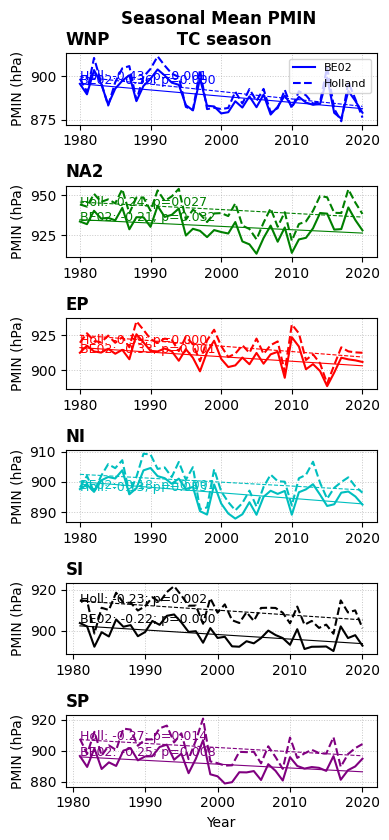

In [79]:
fig = plt.figure(figsize=(4, 10))
path_hpmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_Holland_6MDR/HMPI_500_1980_2020_'
path_epmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_BE02_6MDR/EMPI_500_1980_2020_'
colors = ['b', 'g', 'r', 'c', 'black', 'purple']
for i, basin in enumerate(basins):
    ds1_monthly = epmin_[f'seasonal_year_{basin}'].mean(dim=['latitude', 'longitude'])
    ds2_monthly = hpmin_[f'seasonal_year_{basin}'].mean(dim=['latitude', 'longitude'])
    # plots
    ax = fig.add_subplot(6, 1, i + 1)
    if basin in ['SI', 'SP']:
        x1 = ds1_monthly.season_year.values
        y1 = ds1_monthly.PMIN.values
        x2 = ds2_monthly.season_year.values
        y2 = ds2_monthly.PMIN.values
    else:
        x1 = ds1_monthly.year.values
        y1 = ds1_monthly.PMIN.values
        x2 = ds2_monthly.year.values
        y2 = ds2_monthly.PMIN.values
    
    # Linear regression for BE02
    res_be02 = stats.linregress(x1, y1)
    ax.plot(x1, res_be02.intercept + res_be02.slope * x1, color=colors[i], linestyle='-', linewidth=0.8)
    ax.text(x1[0], y1[0], f'BE02: {res_be02.slope:.2f}; p={res_be02.pvalue:.3f}', fontsize=9, color=colors[i])
    
    # Linear regression for Holland
    res_holland = stats.linregress(x2, y2)
    ax.plot(x2, res_holland.intercept + res_holland.slope * x2, color=colors[i], linestyle='--', linewidth=0.8)
    ax.text(x2[0], y2[0] - 1, f'Holl: {res_holland.slope:.2f}; p={res_holland.pvalue:.3f}', fontsize=9, color=colors[i])

    if basin in ['SI', 'SP']:
        
        ax.plot(ds1_monthly.season_year,ds1_monthly.PMIN,label='BE02', color=colors[i])
        ax.plot(ds2_monthly.season_year,ds2_monthly.PMIN,label='Holland', color=colors[i], linestyle='--')
    else:
        ax.plot(ds1_monthly.year,ds1_monthly.PMIN,label='BE02', color=colors[i])
        ax.plot(ds2_monthly.year,ds2_monthly.PMIN,label='Holland', color=colors[i], linestyle='--')

    ax.set_ylabel('PMIN (hPa)')
    ax.set_title(f'{basin}', loc='left', fontweight='bold')
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)
        ax.set_title("Seasonal Mean PMIN \n TC season", fontsize=12, fontweight='bold')
    if i == 5:
        ax.set_xlabel('Year')
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


### Spatial pattern

In [9]:
def shift_lon_0_360(ds):
    ds = ds.copy()
    ds['longitude'] = (ds.longitude + 360) % 360
    return ds.sortby('longitude')
sst_ = {k: shift_lon_0_360(v) for k, v in sst_.items()}
msl_ = {k: shift_lon_0_360(v) for k, v in msl_.items()}
hpmin_ = {k: shift_lon_0_360(v) for k, v in hpmin_.items()}
epmin_ = {k: shift_lon_0_360(v) for k, v in epmin_.items()}

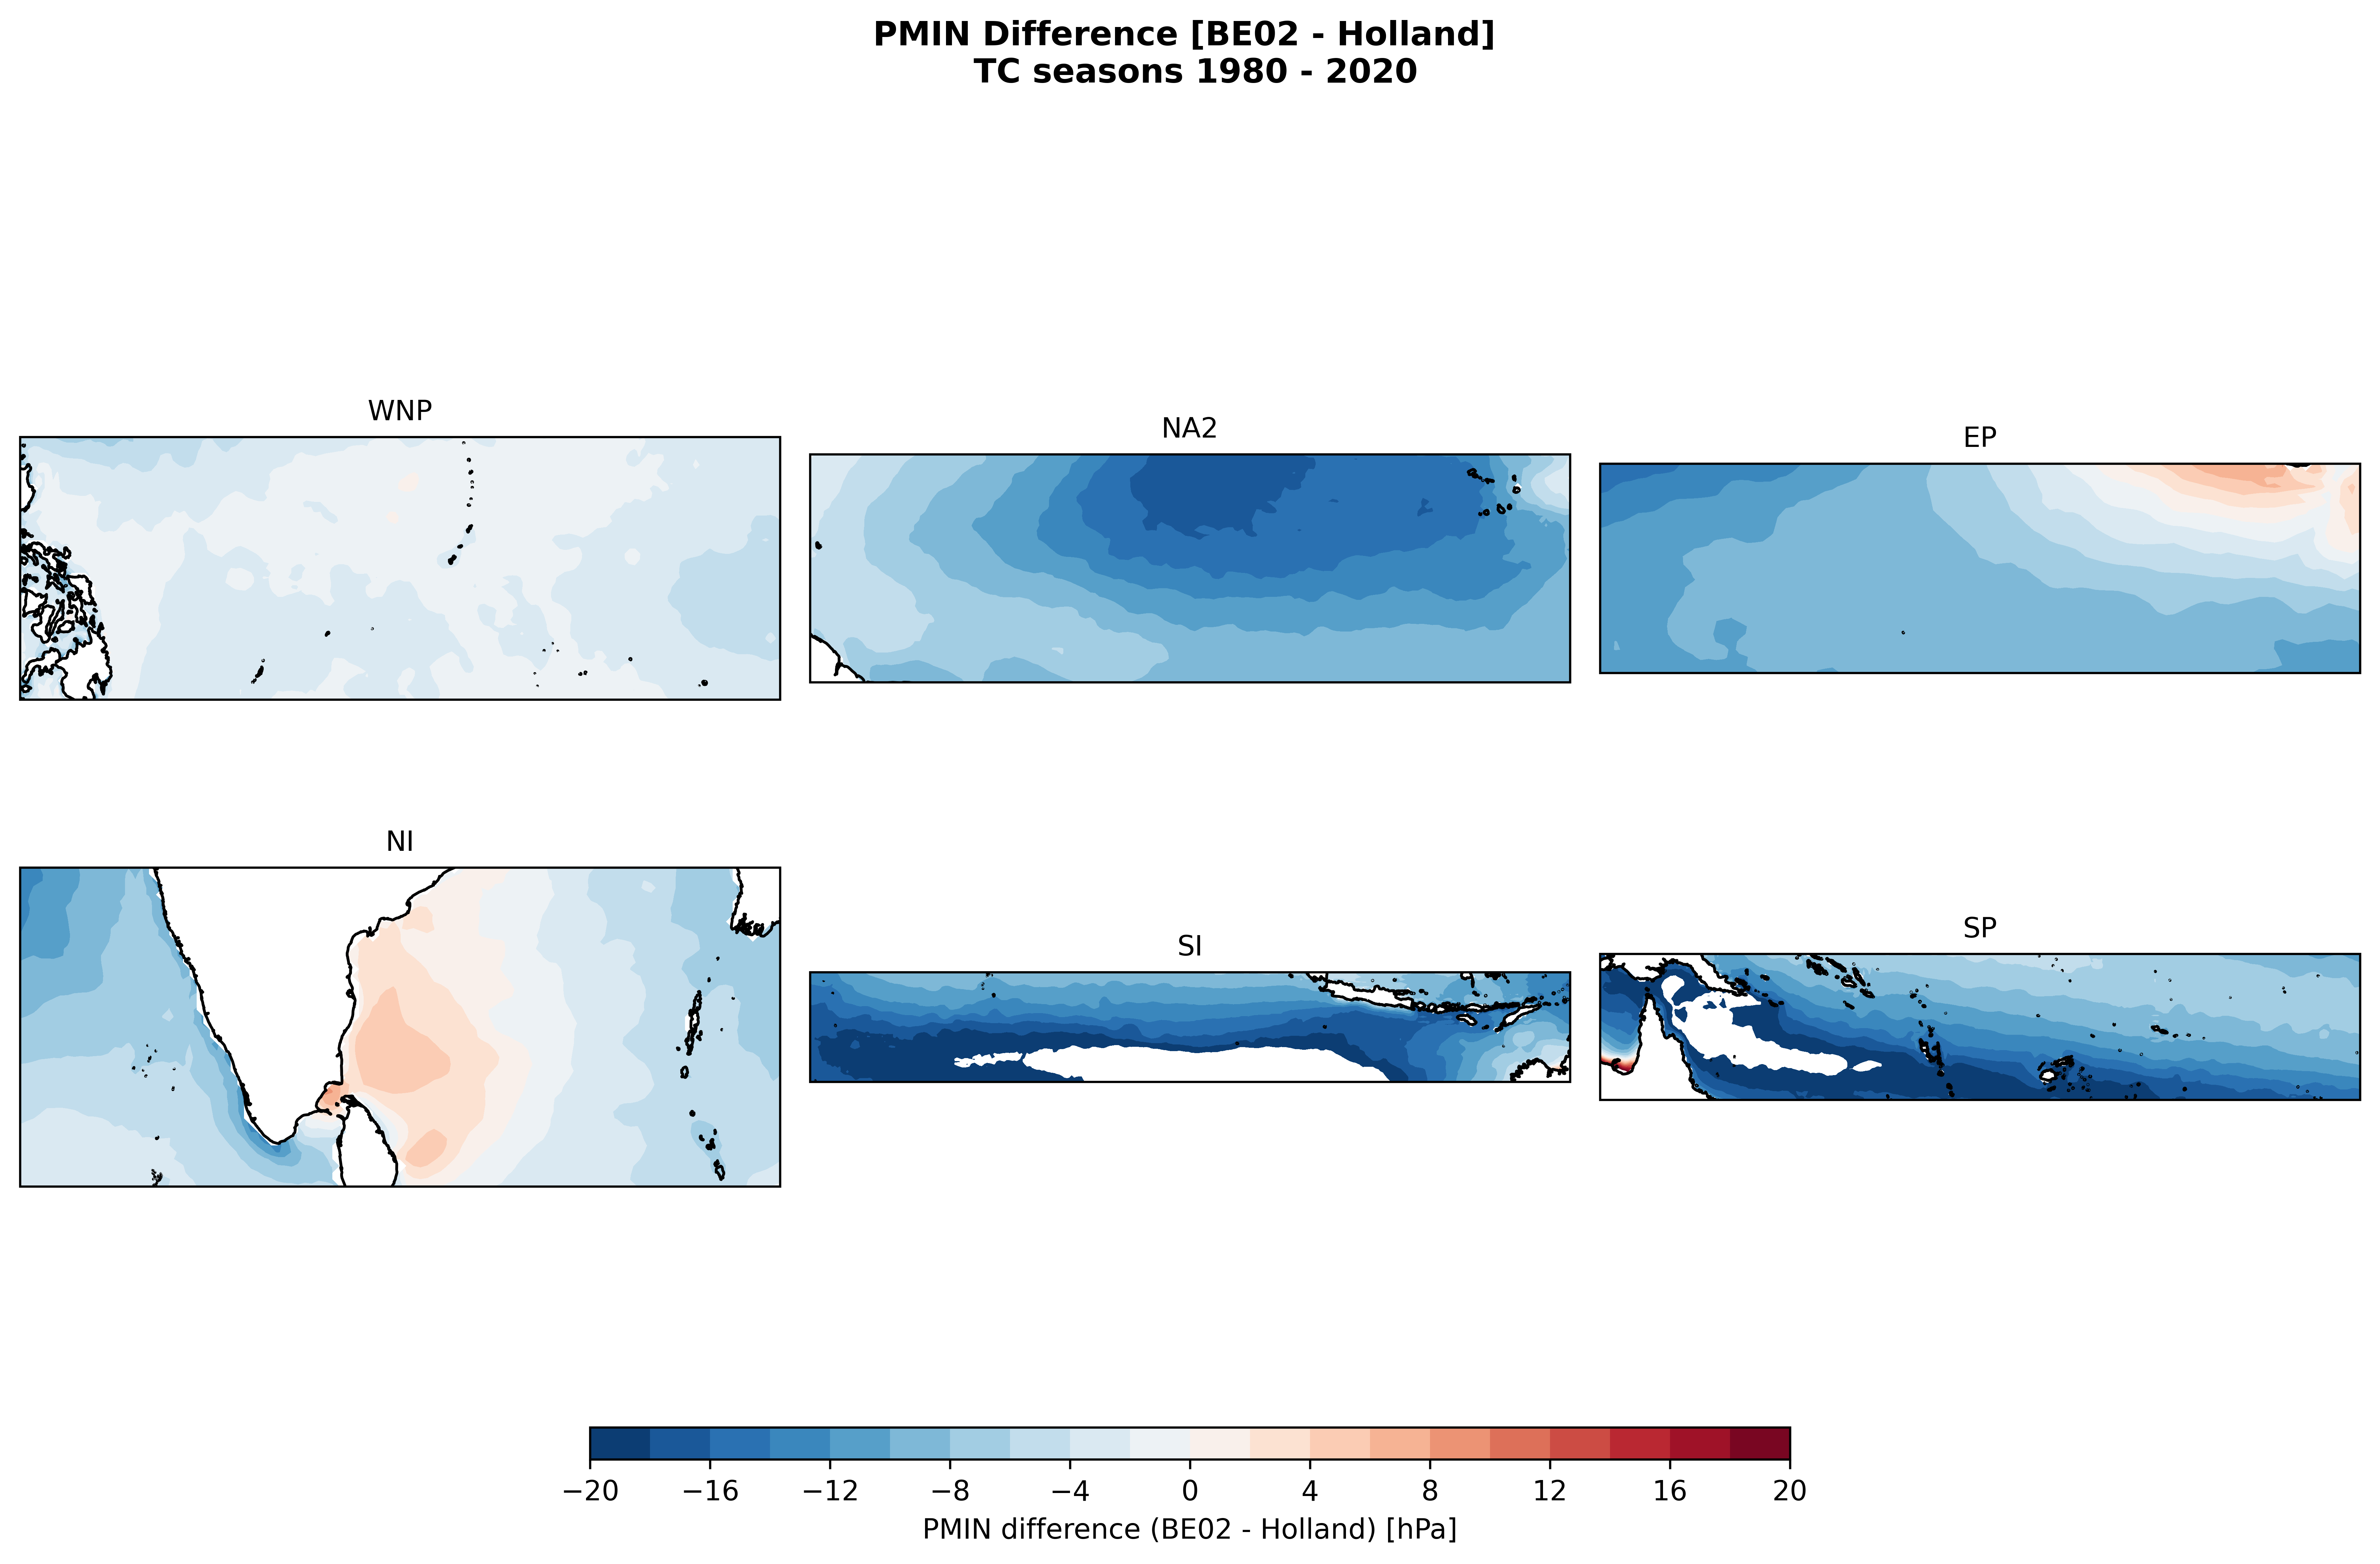

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#
vmn=-20
vmx=20
levels = np.linspace(vmn, vmx, 21) 

for basin in basins:
    epmin_[f'seasonal_mean_{basin}'] = shift_lon_0_360(epmin_[f'seasonal_mean_{basin}'])
    hpmin_[f'seasonal_mean_{basin}'] = shift_lon_0_360(hpmin_[f'seasonal_mean_{basin}'])
fig = plt.figure(figsize=(12, 8), dpi=600)
proj = ccrs.PlateCarree(central_longitude=180)
basins = ['WNP', 'NA2', 'EP', 'NI', 'SI', 'SP']
for i, basin in enumerate(basins):
    ax = fig.add_subplot(2, 3, i + 1, projection=proj)
    diff = epmin_[f'seasonal_mean_{basin}'].PMIN - hpmin_[f'seasonal_mean_{basin}'].PMIN
    cf = ax.contourf(
        hpmin_[f'seasonal_mean_{basin}'].longitude,
        hpmin_[f'seasonal_mean_{basin}'].latitude,
        diff,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r', vmin=vmn, vmax=vmx, levels=levels
    )
    
    ax.coastlines()
    ax.set_title(f'{basin}', fontsize=10)

cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal', ticks=levels[::2])
cbar.set_label('PMIN difference (BE02 - Holland) [hPa]', fontsize=10)

plt.suptitle("PMIN Difference [BE02 - Holland] \n TC seasons 1980 - 2020", fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

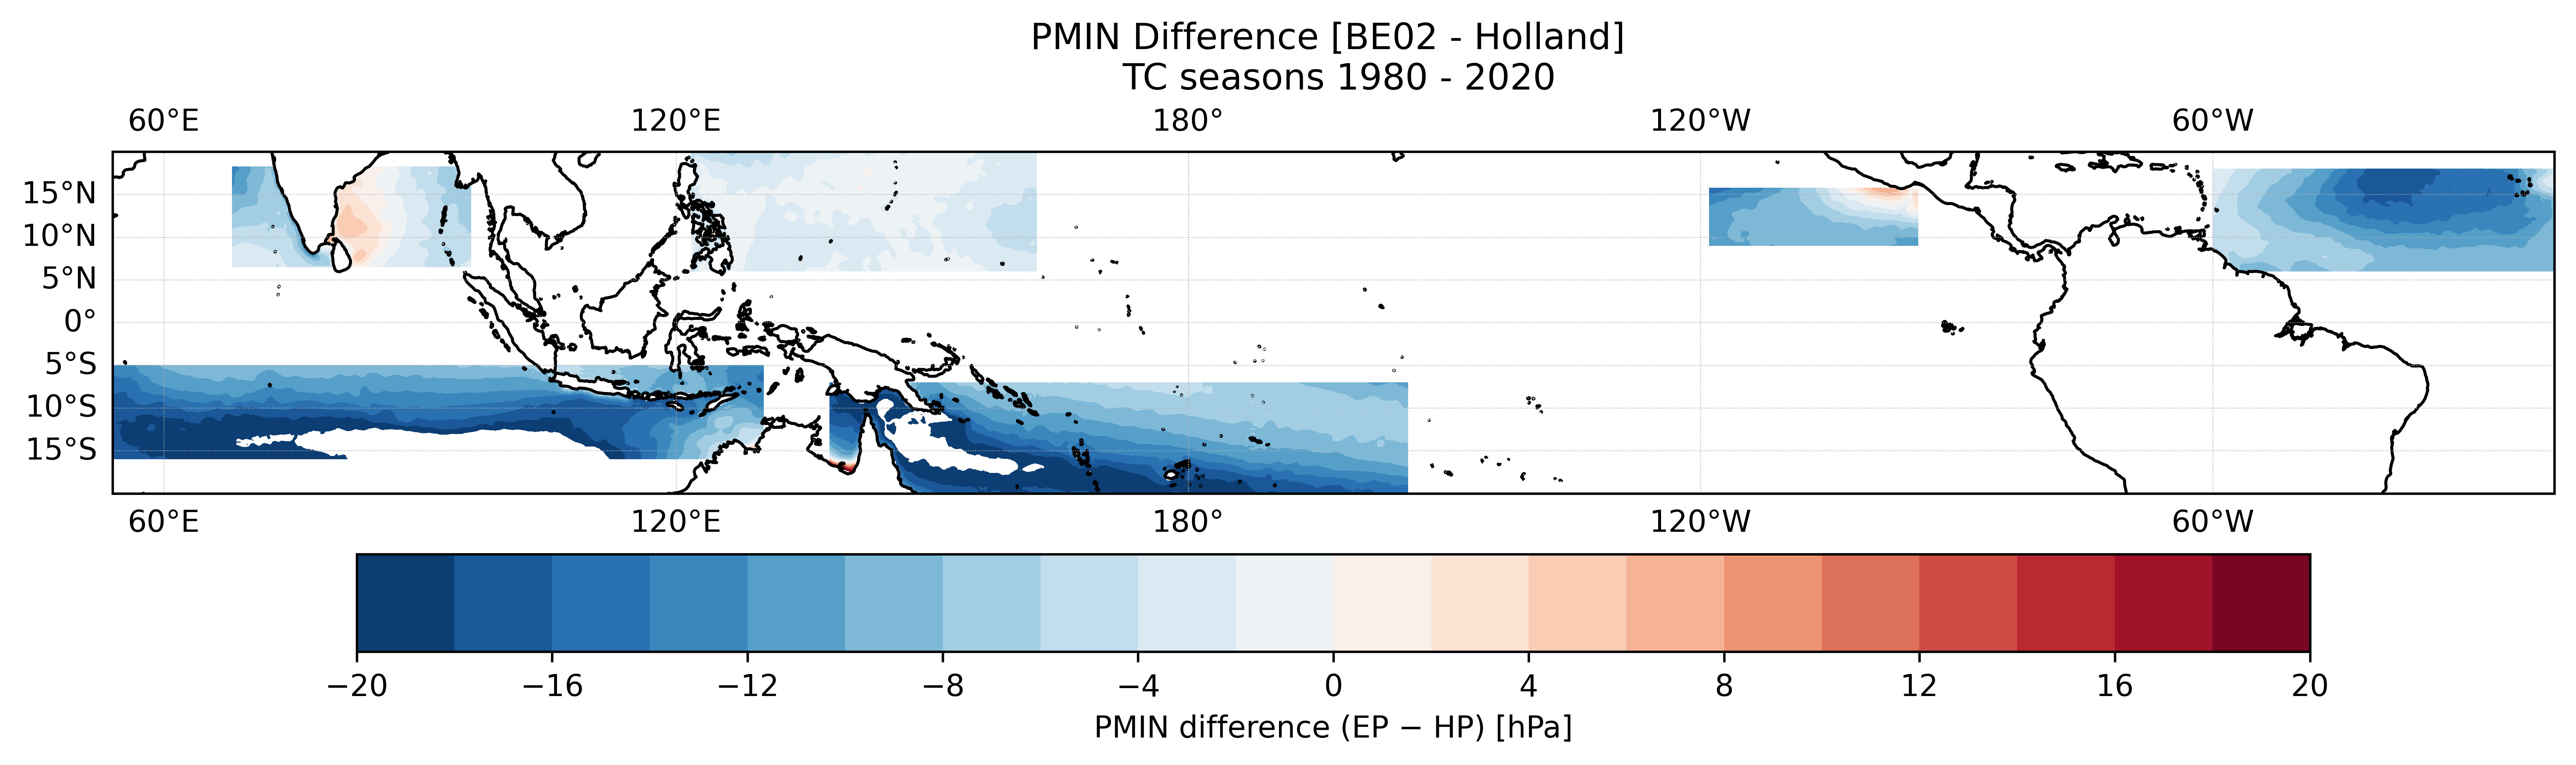

In [22]:
fig = plt.figure(figsize=(12, 6), dpi=600)
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)
# plt.plot; ax = plt.axes; ax = fig.add_subplots()
vmn=-20
vmx=20
levels = np.linspace(vmn, vmx, 21) 

for basin in basins:
    diff = epmin_[f'seasonal_mean_{basin}'].PMIN - hpmin_[f'seasonal_mean_{basin}'].PMIN
    cf = ax.contourf(
        diff.longitude, diff.latitude, diff,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r', vmin=vmn, vmax=vmx, levels=levels
    )
ax.coastlines()
ax.set_title("PMIN Difference [BE02 - Holland] \n TC seasons 1980 - 2020", fontsize=12)
ax.gridlines(draw_labels=True, linewidth=0.3, linestyle=':')
cbar = fig.colorbar(cf, orientation='horizontal', pad=0.05, shrink=0.8, ticks=levels[::2])
cbar.set_label('PMIN difference (EP − HP) [hPa]', fontsize=10)
plt.tight_layout()
plt.show()

### Peak month for SH and NH

In [29]:
def get_sh_peak_mask(time, start_year=1980, end_year=2020):
    """
    Create a boolean mask for Nov–Mar seasonal periods spanning years.
    Returns mask where True indicates Nov(y)-Mar(y+1) within time range.
    """
    import pandas as pd
    time = xr.DataArray(pd.to_datetime(time.values), dims="time")
    mask = xr.zeros_like(time, dtype=bool)
    for y in range(start_year, end_year):
        nov_dec = (time.dt.year == y) & time.dt.month.isin([11])
        jan_feb_mar = (time.dt.year == y + 1) & time.dt.month.isin([1, 2])
        season = nov_dec | jan_feb_mar
        mask = mask | season

    return mask
# extract monthly mean function
def get_peak_mean(ds,SH_=False):
    if SH_:
        time_mask = get_sh_season_mask(ds.time, start_year=1980, end_year=2020)
        season_year = ds.time.dt.year + (ds.time.dt.month <= 2)
        ds_sel = ds.sel(time=time_mask)
        ds_sel = ds_sel.assign_coords(season_year=season_year)
    else:
        months=[8,9,10]
        time_mask = ds.time.dt.month.isin(months)
        ds_sel = ds.sel(time=time_mask)
    return ds_sel

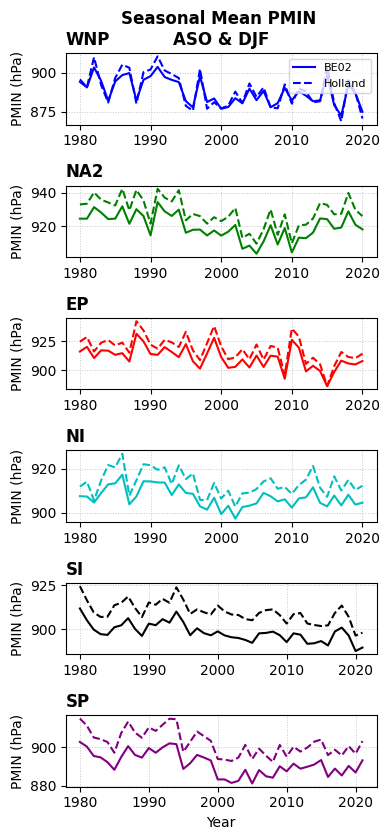

In [46]:
fig = plt.figure(figsize=(4, 10))
path_hpmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_Holland_6MDR/HMPI_500_1980_2020_'
path_epmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_BE02_6MDR/EMPI_500_1980_2020_'
colors = ['b', 'g', 'r', 'c', 'black', 'purple']
for i, basin in enumerate(basins):
    fn1 = f"{path_epmin}{basin}.nc"
    ds1 = xr.open_dataset(fn1)
    ds1_sel = ds1.sel(time=slice('1980-01', '2020-12'))
    fn2 = f"{path_hpmin}{basin}.nc"
    ds2 = xr.open_dataset(fn2)
    ds2_sel = ds2.sel(time=slice('1980-01', '2020-12'))
    if basin in ['SI', 'SP']:
        ds1_sel = get_peak_mean(ds1_sel,SH_=True)
        ds2_sel = get_peak_mean(ds2_sel,SH_=True)
        ds1_sel = ds1_sel.groupby('season_year').mean(dim='time')
        ds2_sel = ds2_sel.groupby('season_year').mean(dim='time')
    else:
        ds1_sel = get_peak_mean(ds1_sel,SH_=False)
        ds2_sel = get_peak_mean(ds2_sel,SH_=False)
        ds1_sel = ds1_sel.groupby(ds1_sel.time.dt.year).mean(dim='time')
        ds2_sel = ds2_sel.groupby(ds2_sel.time.dt.year).mean(dim='time')
    ds1_monthly = ds1_sel.mean(dim=['latitude', 'longitude'])
    ds2_monthly = ds2_sel.mean(dim=['latitude', 'longitude'])
    # plots
    ax = fig.add_subplot(6, 1, i + 1)
    if basin in ['SI', 'SP']:
        season_year
        ax.plot(ds1_monthly.season_year,ds1_monthly.PMIN,label='BE02', color=colors[i])
        ax.plot(ds2_monthly.season_year,ds2_monthly.PMIN,label='Holland', color=colors[i], linestyle='--')
    else:
        ax.plot(ds1_monthly.year,ds1_monthly.PMIN,label='BE02', color=colors[i])
        ax.plot(ds2_monthly.year,ds2_monthly.PMIN,label='Holland', color=colors[i], linestyle='--')

    ax.set_ylabel('PMIN (hPa)')
    ax.set_title(f'{basin}', loc='left', fontweight='bold')
    ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
    if i == 0:
        ax.legend(loc='upper right', fontsize=8)
        ax.set_title("Seasonal Mean PMIN \nASO & DJF", fontsize=12, fontweight='bold')
    if i == 5:
        ax.set_xlabel('Year')
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

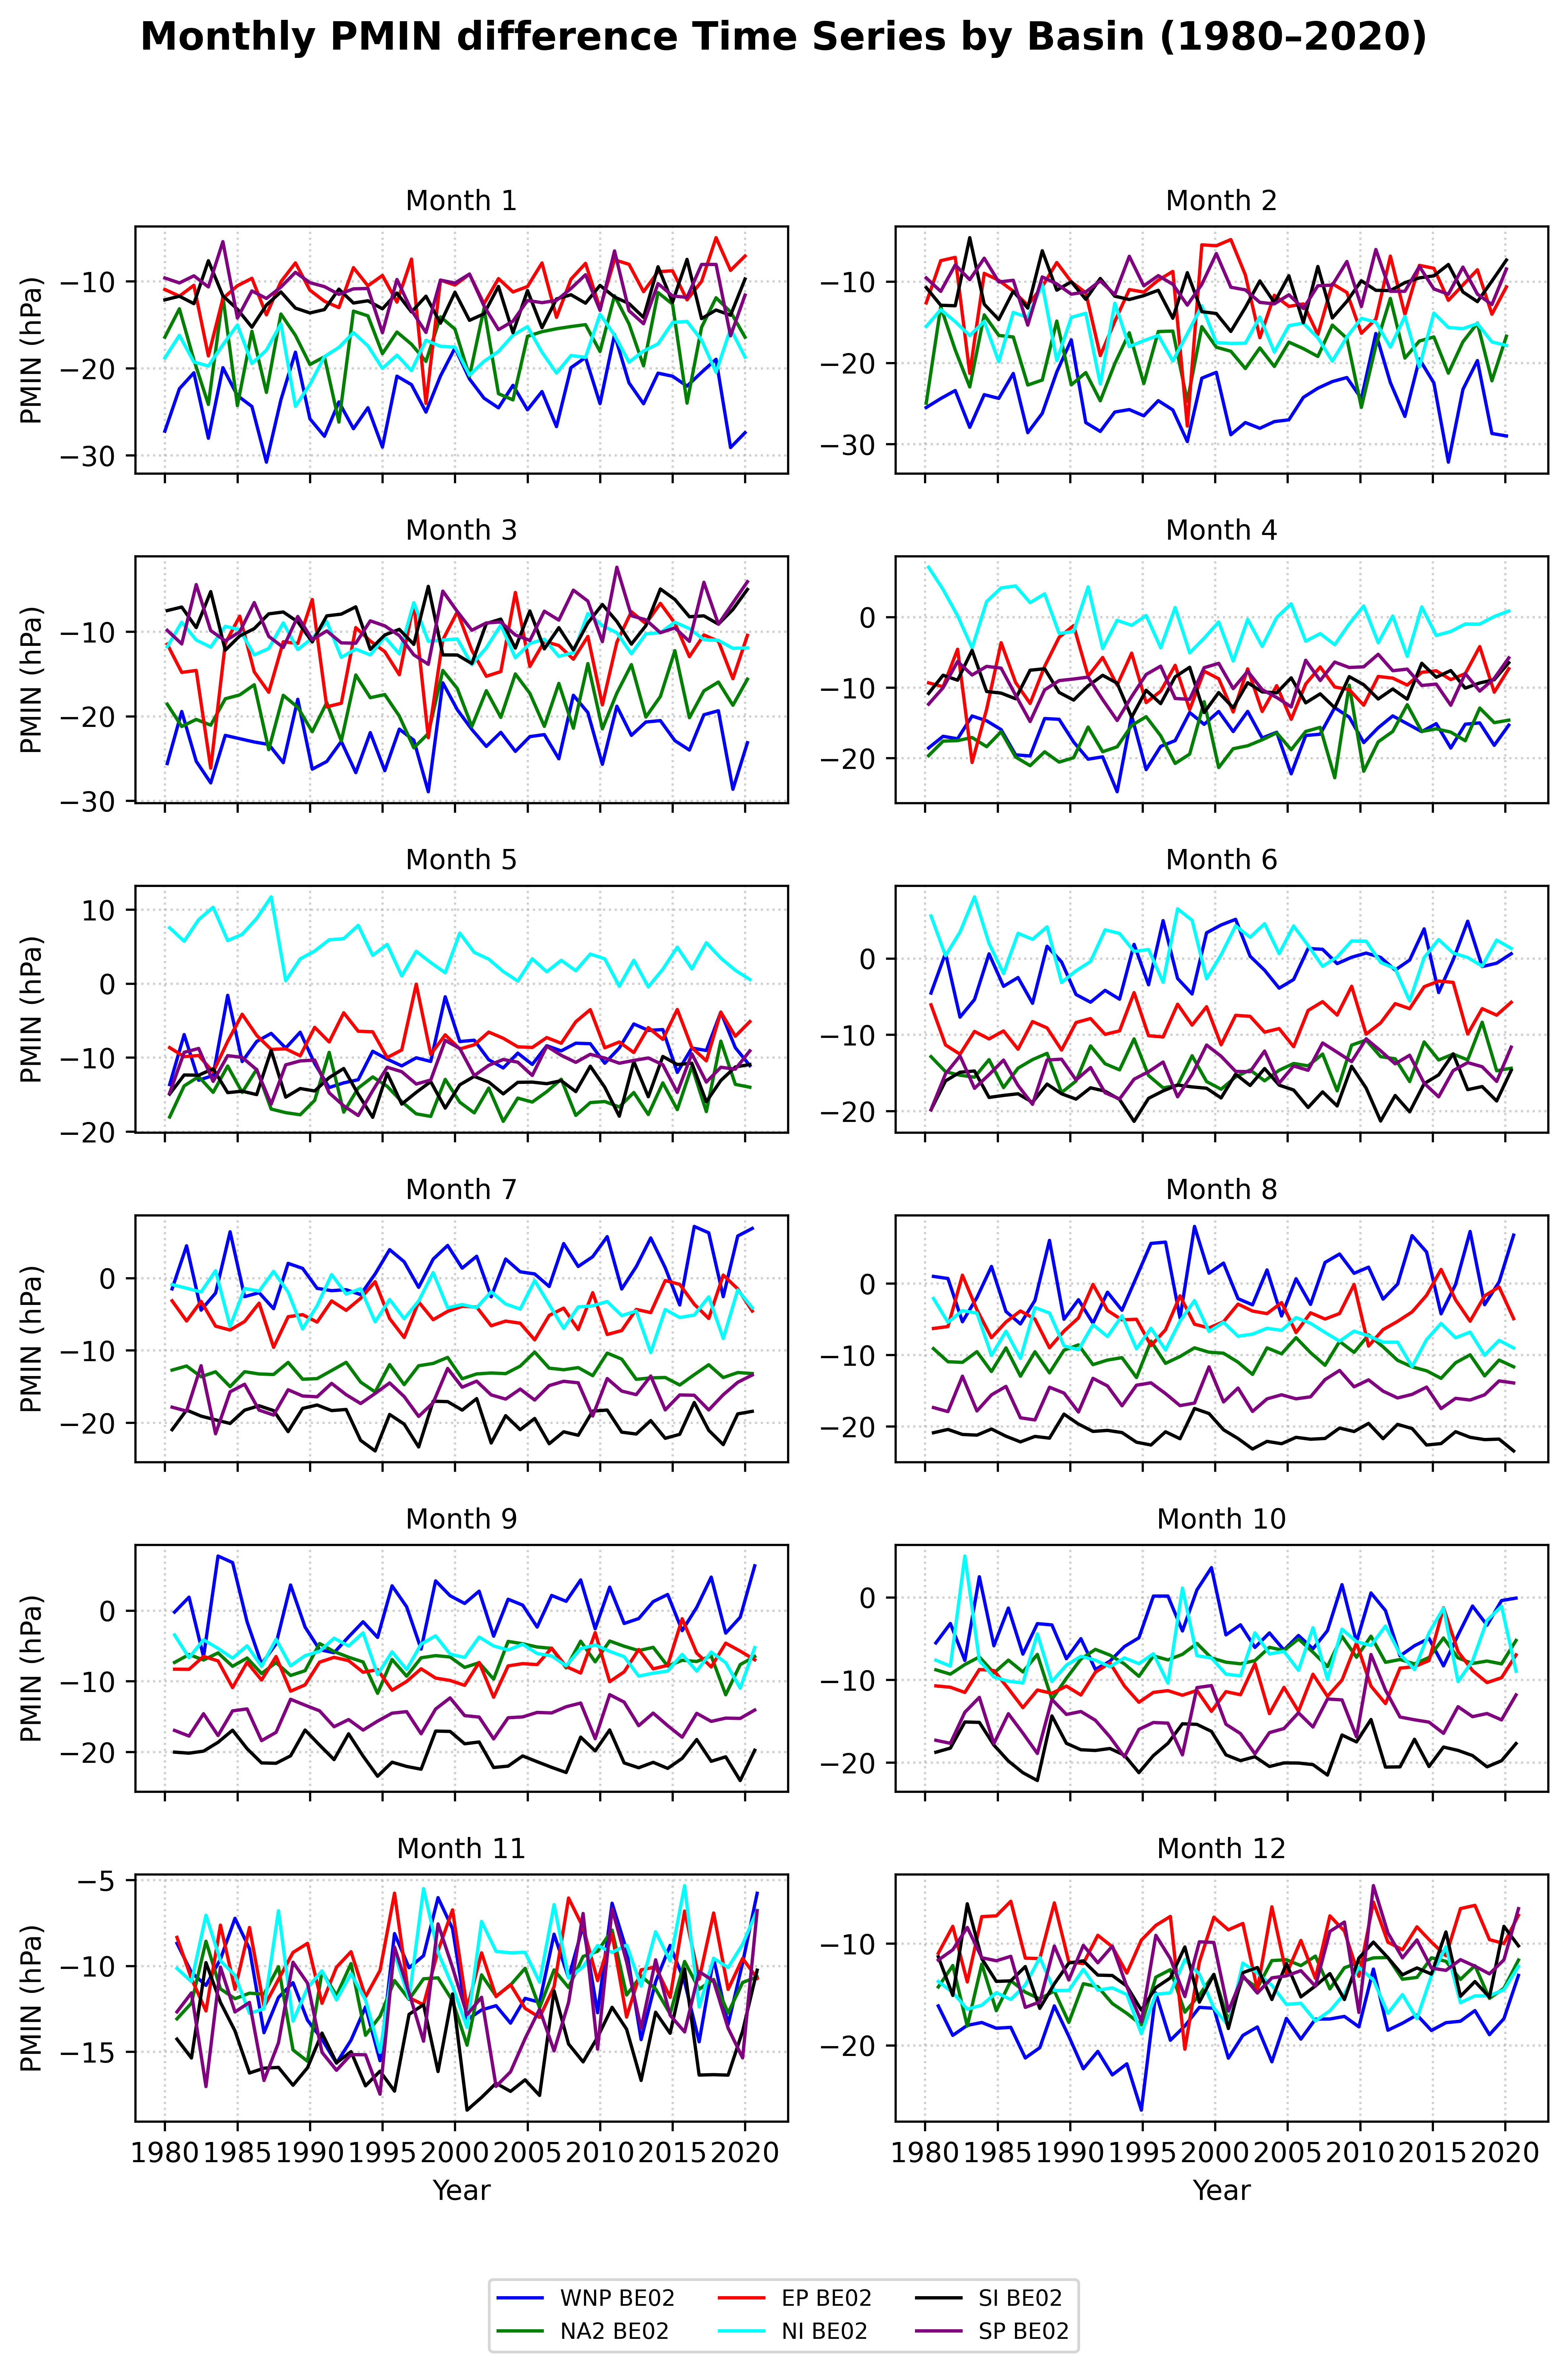

In [100]:
import matplotlib.pyplot as plt
import xarray as xr

basins = ['WNP', 'NA2', 'EP', 'NI', 'SI', 'SP']
colors = ['blue', 'green', 'red', 'cyan', 'black', 'purple']
path_hpmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_Holland_6MDR/HMPI_500_1980_2020_'
path_epmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_BE02_6MDR/EMPI_500_1980_2020_'

fig, axs = plt.subplots(6, 2, figsize=(8, 12), dpi=600, sharex=True)
axs = axs.flatten()

for m in range(1, 13):  # Loop over months 1 to 12
    ax = axs[m - 1]
    for basin, color in zip(basins, colors):
        # Load and select for month
        ds1 = xr.open_dataset(f"{path_epmin}{basin}.nc").sel(time=slice('1980-01', '2020-12'))
        ds2 = xr.open_dataset(f"{path_hpmin}{basin}.nc").sel(time=slice('1980-01', '2020-12'))

        ds1_month = ds1.sel(time=ds1.time.dt.month == m).mean(dim=['latitude', 'longitude'])
        ds2_month = ds2.sel(time=ds2.time.dt.month == m).mean(dim=['latitude', 'longitude'])
        # Plot both models for this basin
        ax.plot(ds1_month.time, ds1_month.PMIN - ds2_month.PMIN, color=color, linewidth=1.2, label=f'{basin} BE02')
        # ax.plot(ds2_month.time, ds2_month.PMIN, color=color, linestyle='--', linewidth=1.2, label=f'{basin} HP')

    ax.set_title(f'Month {m}', fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.6)

    if m in [1, 3, 5, 7, 9, 11]:
        ax.set_ylabel('PMIN (hPa)')
    if m >= 11:
        ax.set_xlabel('Year')

# Avoid duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(unique_labels.values(), unique_labels.keys(), loc='lower center', ncol=3, fontsize=8)

plt.suptitle("Monthly PMIN difference Time Series by Basin (1980–2020)", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()



In [41]:
def get_seasonal_mean(var_name,path):
    res = {}
    basins = ['WNP','NA2','EP','NI','SI','SP']
    for basin in basins:
        fn = f"{path}{basin}.nc"
        ds = xr.open_dataset(fn)[var_name]
        mean_ = np.nanmean(ds,axis=(1,2))[0:41*12]
        res[f'reshape{basin}'] = mean_.reshape(41,12)
        res[f'an_mean{basin}'] = np.nanmean(res[f'reshape{basin}'],axis=1)
    res[f'tc_meanWNP'] =  np.mean((res[f'reshapeWNP'][:,6:10]),axis=1)
    res[f'tc_meanNA2'] =  np.mean((res[f'reshapeNA2'][:,5:10]),axis=1)
    res[f'tc_meanEP'] =  np.mean((res[f'reshapeEP'][:,5:10]),axis=1)
    res[f'tc_meanNI'] =  np.mean((res[f'reshapeNI'][:,3:10]),axis=1)
    sh_ = ['SP','SI']
    for basin in sh_:
        res_N_D = res[f'reshape{basin}'][:40,10:12]
        res_J_M = res[f'reshape{basin}'][1:41,0:3]
        res_season = np.hstack((res_N_D,res_J_M))
        res[f'tc_mean{basin}'] = np.mean((res_season),axis=1)
    return res
#q_basinmean[f'reshape_{basin}'] = q_basinmean[basin].q[0:492,:].values.reshape(41,12,-1)

In [14]:
def get_seasonal_mean_vertical(var_name,path):
    res = {}
    basins = ['WNP','NA2','EP','NI','SI','SP']
    for basin in basins:
        fn = f"{path}{basin}.nc"
        # ds = xr.open_dataset(fn).sel(level = level_)[var_name]
        ds = xr.open_dataset(fn)[var_name]
        mean_ = np.nanmean(ds,axis=(2,3))[0:41*12,:]
        res[f'reshape{basin}'] = mean_.reshape(41,12,-1)
        res[f'an_mean{basin}'] = np.nanmean(res[f'reshape{basin}'],axis=1)
    res[f'tc_meanWNP'] =  np.mean((res[f'reshapeWNP'][:,6:10,:]),axis=1)
    res[f'tc_meanNA2'] =  np.mean((res[f'reshapeNA2'][:,5:10,:]),axis=1)
    res[f'tc_meanEP'] =  np.mean((res[f'reshapeEP'][:,5:10,:]),axis=1)
    res[f'tc_meanNI'] =  np.mean((res[f'reshapeNI'][:,3:10,:]),axis=1)
    sh_ = ['SP','SI']
    for basin in sh_:
        res_N_D = res[f'reshape{basin}'][:40,10:12,:]
        res_J_M = res[f'reshape{basin}'][1:41,0:3,:]
        res_season = np.hstack((res_N_D,res_J_M))
        res[f'tc_mean{basin}'] = np.mean((res_season),axis=1)
    return res

In [15]:
path_msl = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/msl_1980_2023_'
msl_ = get_seasonal_mean('msl',path_msl)
path_sst = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/sst_1980_2023_'
sst_ = get_seasonal_mean('sst',path_sst)
path_hpmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_Holland_6MDR/HMPI_500_1980_2020_'
hpmin_ = get_seasonal_mean('PMIN',path_hpmin)
path_epmin = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/Data_BE02_6MDR/EMPI_500_1980_2020_'
epmin_ = get_seasonal_mean('PMIN',path_epmin)
#

In [158]:
path_t = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/t_1980_2023_'
t_ = get_seasonal_mean_vertical('t',path_t)
path_q = '/g/data/ng72/xw6141/PhD/6MDRHMPIjob/Holland_data/q_1980_2023_'
q_ = get_seasonal_mean_vertical('q',path_q)